<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/uas_DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Data Collection**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
# Load dataset
import pandas as pd

# Membaca file CSV dari Drive
df = pd.read_csv("/content/drive/MyDrive/DM/salaries.csv")

In [82]:
print("Jumlah baris & kolom:", df.shape)

Jumlah baris & kolom: (141566, 11)


In [83]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,Data Quality Analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,Data Quality Analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,Applied Scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,Applied Scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M


#**2. Pre Processing**

In [84]:
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [85]:
# Hapus duplikat jika ada
df.drop_duplicates(inplace=True)

In [86]:
df.drop(columns=['salary'], inplace=True)

#**3. EDA**

###**3.1 Distribusi Gaji (USD)**

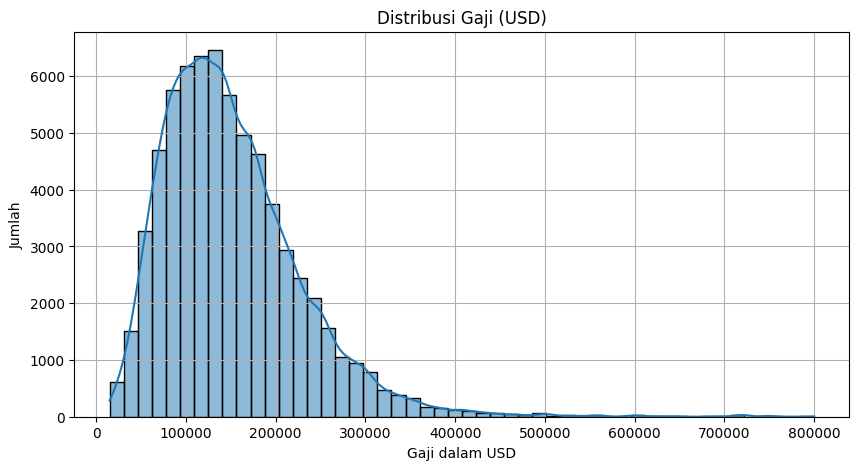

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df['salary_in_usd'], bins=50, kde=True)
plt.title('Distribusi Gaji (USD)')
plt.xlabel('Gaji dalam USD')
plt.ylabel('Jumlah')
plt.grid(True)
plt.show()

###**3.2 Top 10 Job Title berdasarkan Rata-rata Gaji**

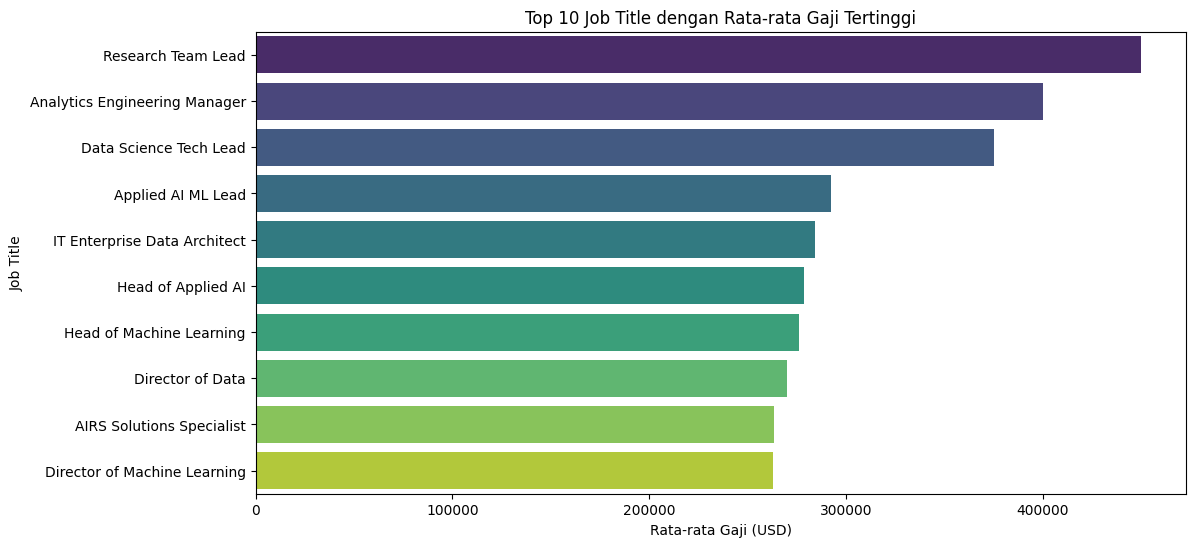

In [88]:
plt.figure(figsize=(12, 6))
top_jobs = df.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_jobs.values, y=top_jobs.index, palette='viridis')
plt.title('Top 10 Job Title dengan Rata-rata Gaji Tertinggi')
plt.xlabel('Rata-rata Gaji (USD)')
plt.ylabel('Job Title')
plt.show()

###**3.3 Tren Gaji dari Tahun ke Tahun**

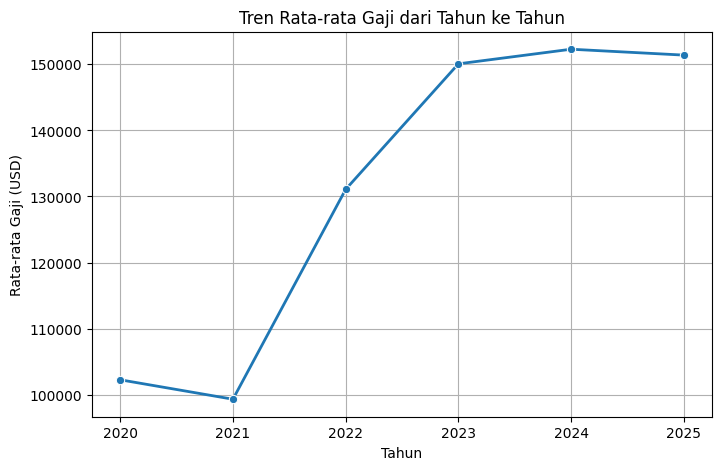

In [89]:
plt.figure(figsize=(8, 5))
avg_salary_by_year = df.groupby('work_year')['salary_in_usd'].mean()
sns.lineplot(x=avg_salary_by_year.index, y=avg_salary_by_year.values, marker='o', linewidth=2)
plt.title('Tren Rata-rata Gaji dari Tahun ke Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Gaji (USD)')
plt.grid(True)
plt.show()

####**3.4 Analisis Job Title Tertentu (Top 5)**

In [174]:
job_focus = [
    'Data Scientist',
    'Data Engineer',
    'Data Analyst',
    'Machine Learning Engineer',
    'AI Engineer'
]

df_focus = df[df['job_title'].isin(job_focus)].copy()
print(df_focus['job_title'].value_counts())

job_title
Data Scientist               6889
Data Engineer                6815
Data Analyst                 6129
Machine Learning Engineer    3346
AI Engineer                  1060
Name: count, dtype: int64


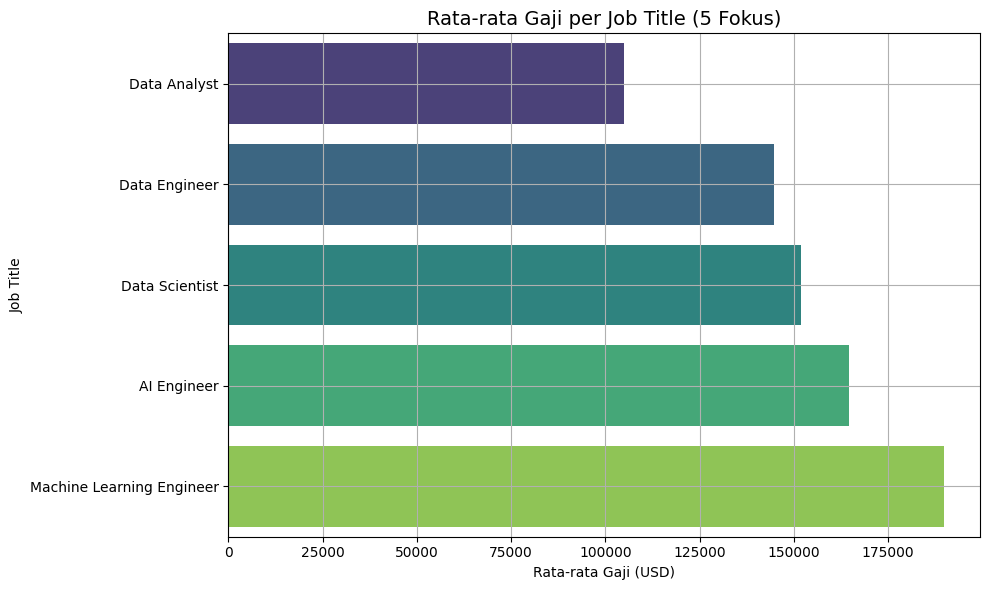

In [175]:
plt.figure(figsize=(10, 6))
avg_salary_focus = df_focus.groupby('job_title')['salary_in_usd'].mean().sort_values()
sns.barplot(x=avg_salary_focus.values, y=avg_salary_focus.index, palette='viridis')
plt.title('Rata-rata Gaji per Job Title (5 Fokus)', fontsize=14)
plt.xlabel('Rata-rata Gaji (USD)')
plt.ylabel('Job Title')
plt.grid(True)
plt.tight_layout()
plt.show()

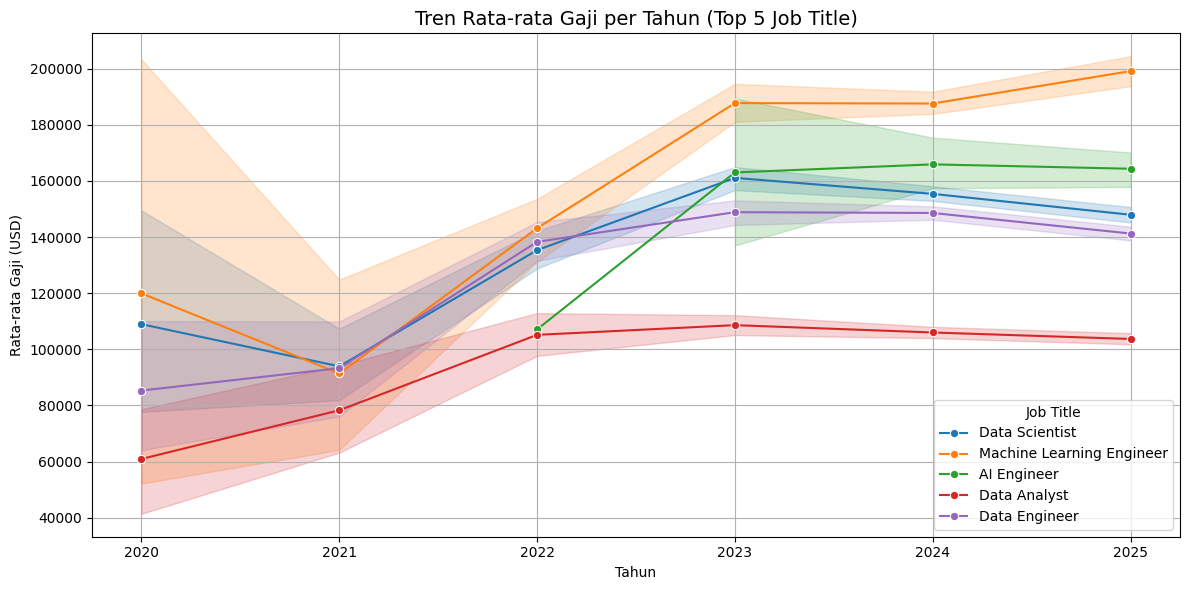

In [178]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_focus, x='work_year', y='salary_in_usd', hue='job_title', marker='o')
plt.title('Tren Rata-rata Gaji per Tahun (Top 5 Job Title)', fontsize=14)
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Gaji (USD)')
plt.legend(title='Job Title')
plt.grid(True)
plt.tight_layout()
plt.show()

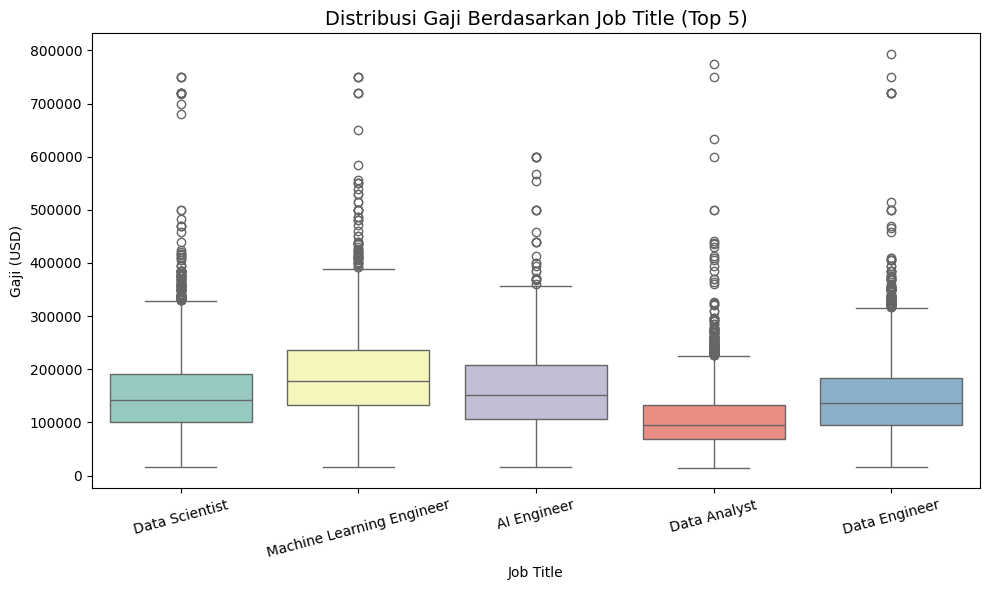

In [177]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_focus, x='job_title', y='salary_in_usd', palette='Set3')
plt.title('Distribusi Gaji Berdasarkan Job Title (Top 5)', fontsize=14)
plt.xlabel('Job Title')
plt.ylabel('Gaji (USD)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

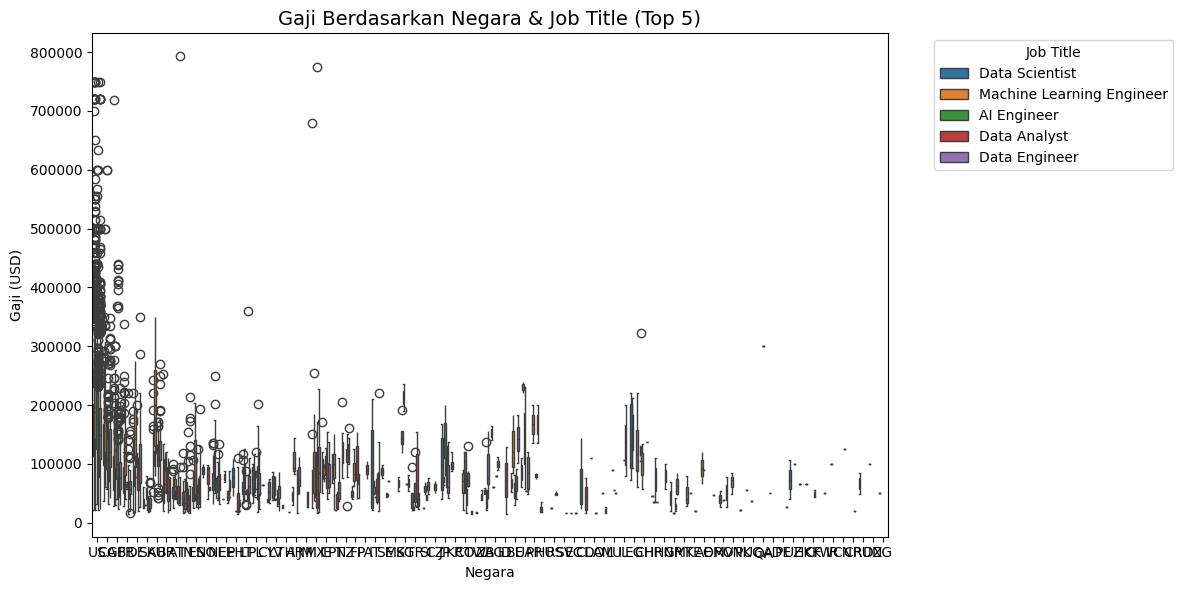

In [180]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_focus, x='employee_residence', y='salary_in_usd', hue='job_title')
plt.title('Gaji Berdasarkan Negara & Job Title (Top 5)', fontsize=14)
plt.xlabel('Negara')
plt.ylabel('Gaji (USD)')
plt.legend(title='Job Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#**4. Feature Engineering**

####**4.1 Mapping Negara menjadi Benua**

In [90]:
import pycountry_convert as pc

# Fungsi konversi dari country **code** (seperti 'US', 'GB') ke benua
def code_to_continent(country_code):
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return {
            "AF": "Africa",
            "NA": "North America",
            "OC": "Oceania",
            "AN": "Antarctica",
            "AS": "Asia",
            "EU": "Europe",
            "SA": "South America"
        }.get(continent_code, "Other")
    except:
        return "Other"

In [91]:
# Terapkan ke employee_residence dan company_location
df['employee_continent'] = df['employee_residence'].apply(code_to_continent)

In [92]:
df['company_continent'] = df['company_location'].apply(code_to_continent)

####**4.2 Gaji Berdasarkan Quartal**

In [93]:
# Membuat kategori gaji: Low, Medium, High, Very High
df['salary_level'] = pd.qcut(df['salary_in_usd'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

####**4.3 Hasil Feature Baru**

In [95]:
df[['salary_in_usd', 'salary_level', 'employee_continent', 'company_continent']].head(10)

,salary_in_usd,salary_level,employee_continent,company_continent
0,75949,Low,Europe,Europe
1,60759,Low,Europe,Europe
2,266000,Very High,North America,North America
3,204000,Very High,North America,North America
4,291000,Very High,North America,North America
5,197000,Very High,North America,North America
6,349000,Very High,North America,North America
7,248000,Very High,North America,North America
8,279400,Very High,North America,North America
9,211582,Very High,North America,North America


#**5. Encode & Split**

####**5.1 Drop Kolom Redundan**

In [96]:
df_model = df.copy()

# Drop kolom yang tidak dipakai
drop_cols = []
if 'salary_currency' in df_model.columns:
    drop_cols.append('salary_currency')
if 'salary' in df_model.columns:  # antisipasi
    drop_cols.append('salary')

if drop_cols:
    df_model.drop(columns=drop_cols, inplace=True)

####**5.2 Label Encoding Kolom Kategorikal**

In [97]:
from sklearn.preprocessing import LabelEncoder

# Daftar kolom kategorikal
categorical_features = [
    'experience_level', 'employment_type', 'job_title',
    'employee_residence', 'company_location', 'company_size',
    'employee_continent', 'company_continent', 'salary_level'
]

# Encoding
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le  # simpan encoder untuk prediksi nanti

####**5.3 Split Feature & Label**

In [99]:
from sklearn.model_selection import train_test_split

# Definisi fitur (X) dan target (y)
X = df_model.drop(['salary_in_usd'], axis=1)
y = df_model['salary_in_usd']

# Split data: train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Info bentuk data
print("X_train:", X_train.shape, "| X_test:", X_test.shape)

X_train: (54310, 11) | X_test: (13578, 11)


In [100]:
print("Feature dtypes:\n", X_train.dtypes)

Feature dtypes:
 work_year             int64
experience_level      int64
employment_type       int64
job_title             int64
employee_residence    int64
remote_ratio          int64
company_location      int64
company_size          int64
employee_continent    int64
company_continent     int64
salary_level          int64
dtype: object


#**6. Model Training**

####**6.1 Inisialisasi dan Training Model**

In [131]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [127]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

####**6.2 Prediksi dan Evaluasi Model**

In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prediksi
rf_preds = rf_model.predict(X_test)
dt_preds = dt_model.predict(X_test)

# Fungsi evaluasi
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Evaluation:")
    print(f"Mean Absolute Error/MAE  : {mae:.2f}")
    print(f"Root Mean Squared Error/RMSE : {rmse:.2f}")
    print(f"R-Squared/R2   : {r2:.4f}")

In [133]:
evaluate_model("Random Forest", y_test, rf_preds)

Random Forest Evaluation:
Mean Absolute Error/MAE  : 20737.91
Root Mean Squared Error/RMSE : 36311.41
R-Squared/R2   : 0.7821


In [134]:
evaluate_model("Decision Tree", y_test, dt_preds)

Decision Tree Evaluation:
Mean Absolute Error/MAE  : 21244.63
Root Mean Squared Error/RMSE : 37334.62
R-Squared/R2   : 0.7697


#**7. Visualisasi**

####**7.1 Visualisasi: Actual vs Predicted Salary**

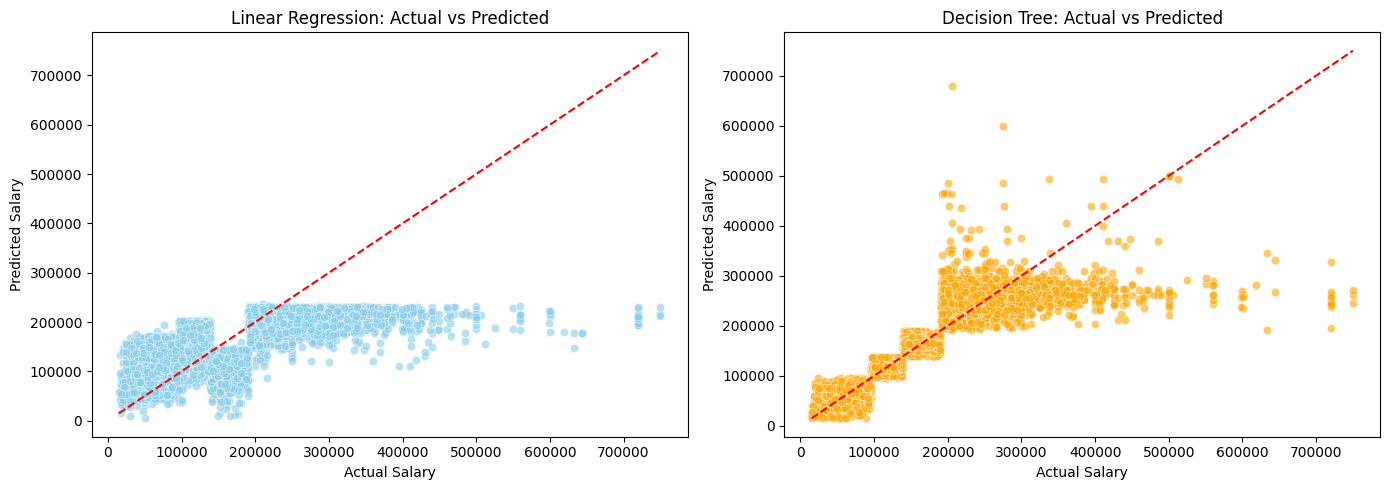

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))

# Linear Regression
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=lr_preds, alpha=0.6, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Linear Regression: Actual vs Predicted')

# Decision Tree
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=dt_preds, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Decision Tree: Actual vs Predicted')

plt.tight_layout()
plt.show()

####**7.2 Feature Importance (Decision Tree)**

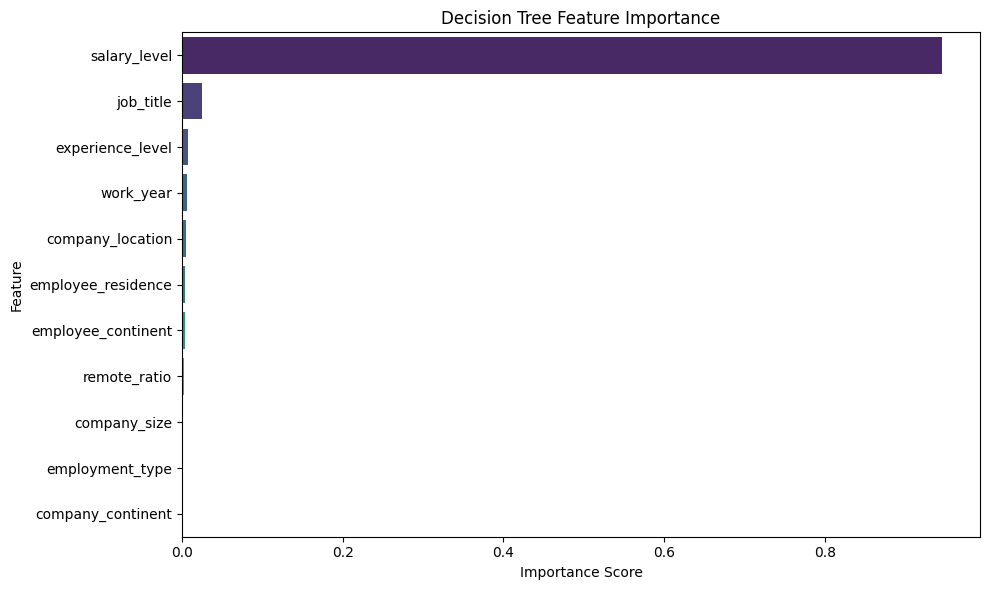

In [112]:
# Feature Importance
importances = dt_model.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
plt.title("Decision Tree Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

####**7.3 Visualisasi Gaji per Negara (Top 15)**

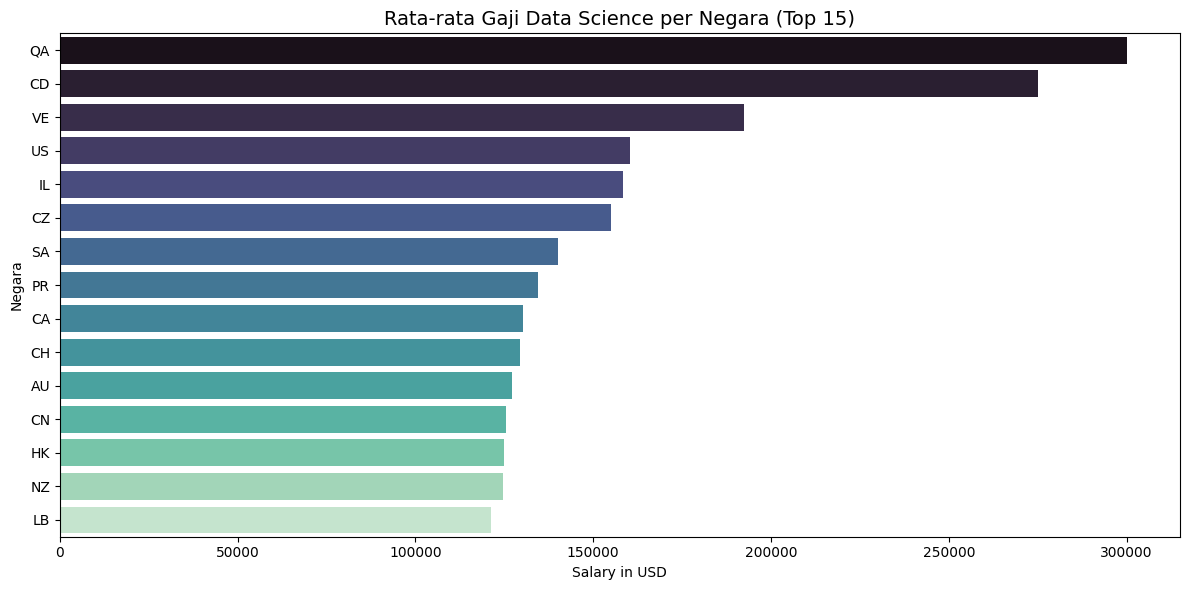

In [114]:
avg_salary_country = df.groupby('employee_residence')['salary_in_usd'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_salary_country.values, y=avg_salary_country.index, palette='mako')
plt.title('Rata-rata Gaji Data Science per Negara (Top 15)', fontsize=14)
plt.xlabel('Salary in USD')
plt.ylabel('Negara')
plt.tight_layout()
plt.show()

####**7.4 Visualisasi Gaji per Job Title (Top 15)**

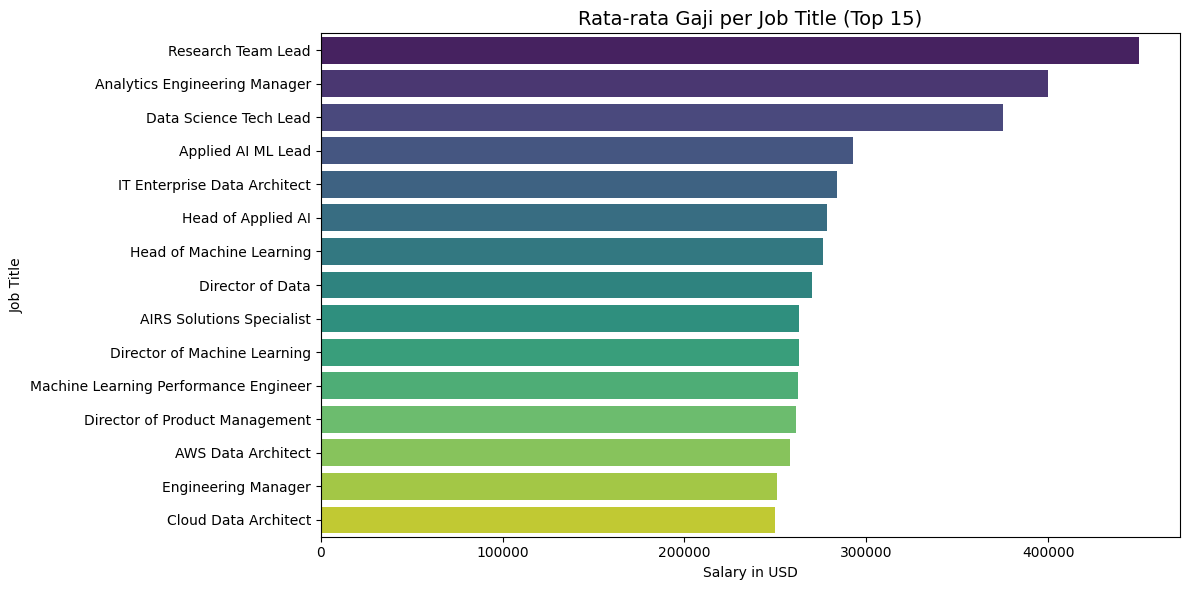

In [116]:
avg_salary_job = df.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_salary_job.values, y=avg_salary_job.index, palette='viridis')
plt.title('Rata-rata Gaji per Job Title (Top 15)', fontsize=14)
plt.xlabel('Salary in USD')
plt.ylabel('Job Title')
plt.tight_layout()
plt.show()

####**7.5 Distribusi Gaji Berdasarkan Remote Ratio**

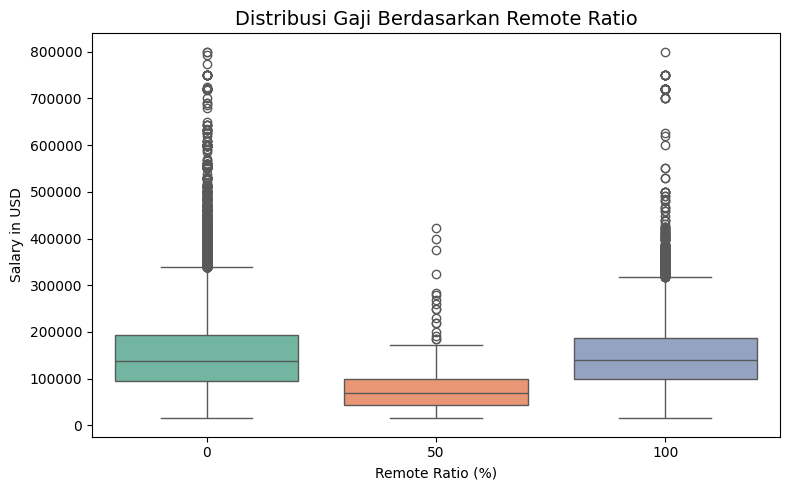

In [117]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='remote_ratio', y='salary_in_usd', palette='Set2')
plt.title('Distribusi Gaji Berdasarkan Remote Ratio', fontsize=14)
plt.xlabel('Remote Ratio (%)')
plt.ylabel('Salary in USD')
plt.tight_layout()
plt.show()

####**7.6 Rata-rata Gaji per Tahun (Lineplot)**

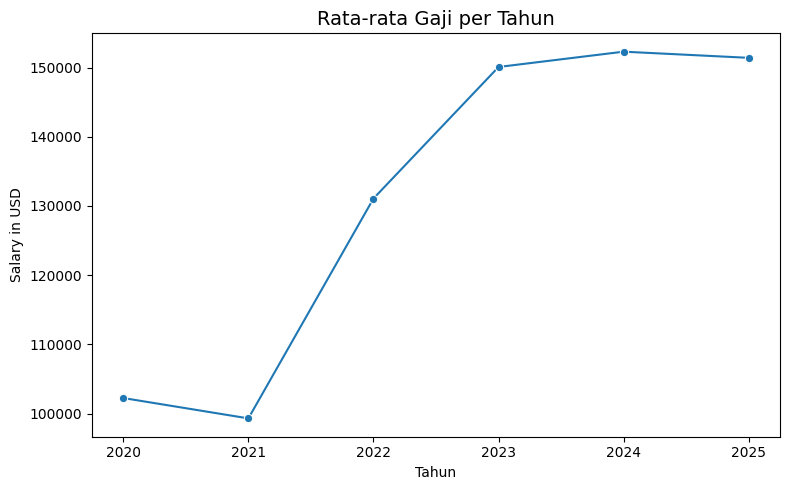

In [118]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x='work_year', y='salary_in_usd', estimator='mean', ci=None, marker='o')
plt.title('Rata-rata Gaji per Tahun', fontsize=14)
plt.xlabel('Tahun')
plt.ylabel('Salary in USD')
plt.tight_layout()
plt.show()

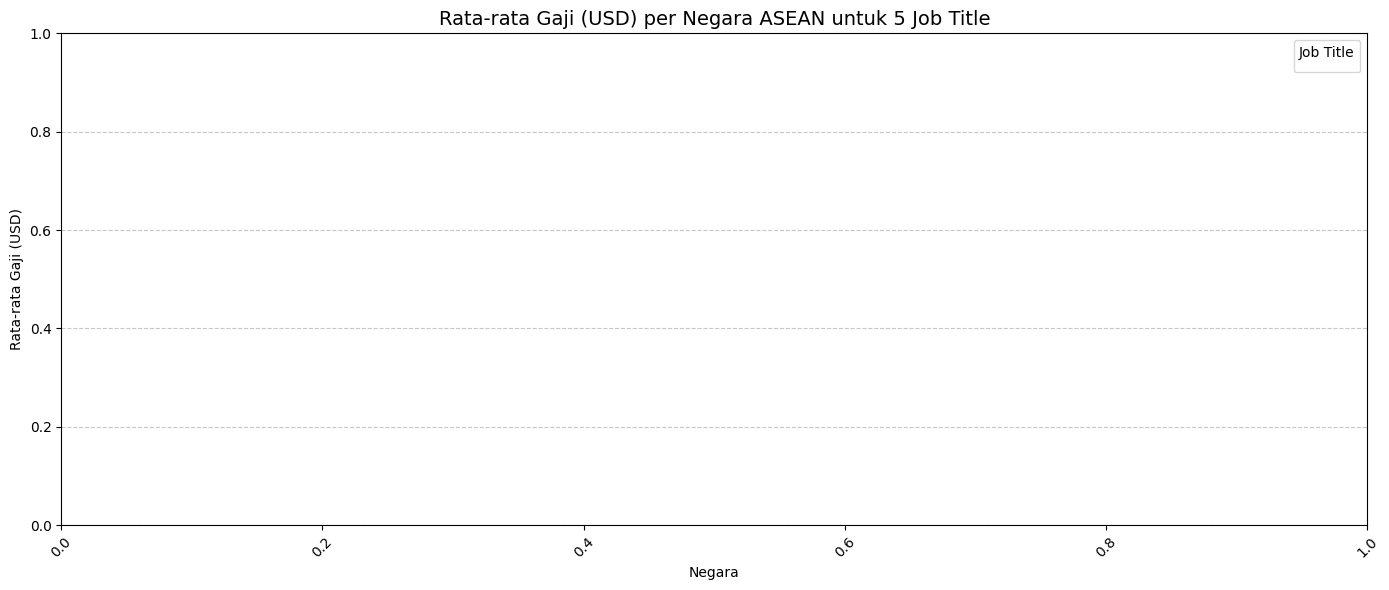

In [181]:
# 7.7 Visualisasi Gaji per Negara ASEAN untuk 5 Job Title Populer

# Daftar negara ASEAN berdasarkan kode
asean_countries = ['Indonesia', 'Malaysia', 'Singapore', 'Thailand', 'Vietnam',
                   'Philippines', 'Brunei', 'Myanmar', 'Cambodia', 'Laos']

# Top 5 Job Title
top_jobs = ['Data Scientist', 'Data Engineer', 'Data Analyst',
            'Machine Learning Engineer', 'AI Engineer']

# Filter data ASEAN dan Top 5 job
df_asean_jobs = df[df['job_title'].isin(top_jobs) & df['company_location'].isin(asean_countries)]

# Hitung rata-rata gaji per negara ASEAN dan job title
asean_salary = df_asean_jobs.groupby(['company_location', 'job_title'])['salary_in_usd'].mean().reset_index()

# Visualisasi menggunakan seaborn barplot
plt.figure(figsize=(14, 6))
sns.barplot(data=asean_salary, x='company_location', y='salary_in_usd', hue='job_title')
plt.title('Rata-rata Gaji (USD) per Negara ASEAN untuk 5 Job Title', fontsize=14)
plt.xlabel('Negara')
plt.ylabel('Rata-rata Gaji (USD)')
plt.legend(title='Job Title')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#**8. Prediksi Gaji Interaktif**

####**8.1 Prediksi Gaji Berdasarkan Input Manual**

In [120]:
def predict_salary_interactive(model, label_encoders_dict, input_dict):
    import pandas as pd

    # Konversi input user ke DataFrame
    input_df = pd.DataFrame([input_dict])

    # Lakukan encoding untuk fitur kategorikal
    categorical_features_in_input = [col for col in input_df.columns if col in label_encoders_dict]

    for col in categorical_features_in_input:
        try:
            input_df[col] = label_encoders_dict[col].transform(input_df[col])
        except ValueError as e:
            print(f"Error encoding column '{col}': {e}")
            print(f"Pastikan input untuk '{col}' sesuai dengan data training.")
            return None

    # Prediksi
    predicted_salary = model.predict(input_df)
    return predicted_salary[0]

In [161]:
# Contoh input user
sample_input = {
    'work_year': 2025,
    'experience_level': 'SE',    # MI, SE, EN, EX
    'employment_type': 'FT',     # FT, PT, CT, FL
    'job_title': 'Research Team Lead',
    'employee_residence': 'US',
    'remote_ratio': 100,         # 0, 50, 100
    'company_location': 'US',
    'company_size': 'L',         # S, M, L
    'employee_continent': 'North America',
    'company_continent': 'North America',
    'salary_level': 'High'
}

In [164]:
best_model_1 = rf_model

# Prediksi Model Random Forest
predicted = predict_salary_interactive(best_model_1, label_encoders, sample_input)

# Tampilkan hasil
if predicted is not None:
    print(f"Predicted Salary: ${predicted:,.2f}")

Predicted Salary: $162,624.17
